In [1]:
import pandas as pd
import numpy as np
import copy
import locale
import math
import matplotlib.pyplot as plt
%matplotlib inline

from modules.files import *
from modules.data import *
from modules.enums import *

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

locale.setlocale( locale.LC_ALL, '')


#import_csv("Neighborhood_zhvi_uc_condo_tier_0.33_0.67_sm_sa_mon.csv")


'en_US.UTF-8'

In [3]:
#condo_data = import_csv("ingested_condo.csv")
#sfr_data = import_csv("ingested_singlefamilyresidence.csv")

In [3]:

#df2 = df1.pivot(index="Date", columns=["RegionName", "Housing Type"], values="% Change")
#df2 = df2.resample("Y").mean()
#df2.head()
#df2.plot(legend=False)

In [115]:
data = get_baseline_data(False, True)

df1 = data.copy(deep=True)

data = df1.reset_index("Housing Type") # remove multiindex to filter on housing type

data.head(10)

,Housing Type,City,State,ZHVI Start,Start Date,ZHVI End,End Date,ZHVI Min,ZHVI Max,Years Diff,% Per Year
RegionName,,,,,,,,,,,
90046,SingleFamilyResidence,Los Angeles,CA,172655.0,1996-01-31,2008581.0,2021-02-28,172655.0,2008581.0,25.1,10.270304
11201,SingleFamilyResidence,New York,NY,467848.0,1996-01-31,2966753.0,2021-02-28,467848.0,3049533.0,25.1,7.636416
11206,SingleFamilyResidence,New York,NY,180911.0,1996-01-31,1129253.0,2021-02-28,180694.0,1133223.0,25.1,7.568796
20002,SingleFamilyResidence,Washington,DC,146125.0,1996-01-31,802620.0,2021-02-28,135970.0,802620.0,25.1,7.022114
90046,Condo,Los Angeles,CA,146200.0,1996-01-31,786405.0,2021-02-28,137765.0,786405.0,25.1,6.932941
11201,Condo,New York,NY,168301.0,1996-01-31,841613.0,2021-02-28,164529.0,910432.0,25.1,6.622689
11226,SingleFamilyResidence,New York,NY,215405.0,1996-01-31,1075986.0,2021-02-28,211407.0,1075986.0,25.1,6.618044
10011,Condo,New York,NY,170150.0,1996-01-31,846310.0,2021-02-28,170150.0,1057748.0,25.1,6.599919
20009,SingleFamilyResidence,Washington,DC,185511.0,1996-01-31,917701.0,2021-02-28,179545.0,917701.0,25.1,6.576784


In [33]:
# summary table

default_groupby = ["Housing Type"]

summary_dataframe = pd.DataFrame()
summary_dataframe["% Per Year Min"] = data.groupby(default_groupby)["% Per Year"].min()
summary_dataframe["% Per Year Max"] = data.groupby(default_groupby)["% Per Year"].max()
summary_dataframe["% Per Year Avg"] = data.groupby(default_groupby)["% Per Year"].mean()
summary_dataframe["Years Diff Min"] = data.groupby(default_groupby)["Years Diff"].min()
summary_dataframe["Years Diff Max"] = data.groupby(default_groupby)["Years Diff"].max()
summary_dataframe["Years Diff Avg"] = data.groupby(default_groupby)["Years Diff"].mean()

summary_dataframe

,% Per Year Min,% Per Year Max,% Per Year Avg,Years Diff Min,Years Diff Max,Years Diff Avg
Housing Type,,,,,,
Condo,-0.283760,6.932941,3.912264,5.1,25.1,22.268
SingleFamilyResidence,-1.209351,10.270304,3.637877,11.7,25.1,22.898


<AxesSubplot:xlabel='ZHVI End', ylabel='% Per Year'>

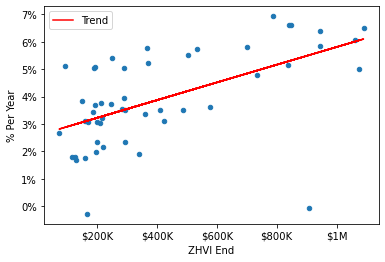

In [116]:
# highest condos mapped
condodata = data[data["Housing Type"]=="Condo"]

plot = condodata.plot(kind='scatter', x = 'ZHVI End', y = '% Per Year')

def format_func(value, tick_number):
    currency = locale.currency(value, grouping=True)
    currency_no_decimal = currency.split('.')[0]        
    if currency_no_decimal.find(',') != -1:
        currency_no_decimal = currency_no_decimal[:currency_no_decimal.index(',')]
        if currency.count(',') == 1:
            currency_no_decimal+="K"
        elif currency.count(',') == 2:
            currency_no_decimal+="M"
    return currency_no_decimal

def percent_formatter(value, tick_number):
    return "{}%".format(int(value))

plot.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
plot.yaxis.set_major_formatter(plt.FuncFormatter(percent_formatter))


# https://towardsdatascience.com/regression-plots-with-pandas-and-numpy-faf2edbfad4f
d = np.polyfit(condodata['ZHVI End'],condodata['% Per Year'],1)
f = np.poly1d(d)

condodata.insert(6,'Trend',f(condodata['ZHVI End']))

condodata.plot(x='ZHVI End', y='Trend',color='Red',ax=plot)

<AxesSubplot:xlabel='ZHVI End', ylabel='% Per Year'>

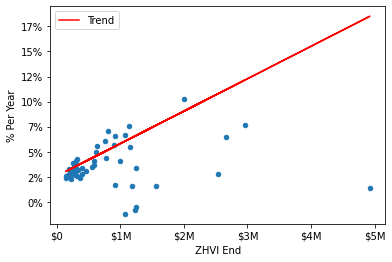

In [129]:
# highest sfr summary table
sfrdata = data[data["Housing Type"]=="SingleFamilyResidence"]

plot = sfrdata.plot(kind='scatter', x = 'ZHVI End', y = '% Per Year')

plot.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
plot.yaxis.set_major_formatter(plt.FuncFormatter(percent_formatter))

d = np.polyfit(condodata['ZHVI End'],condodata['% Per Year'],1)
f = np.poly1d(d)

sfrdata.insert(len(sfrdata.columns),'Trend',f(sfrdata['ZHVI End']))

sfrdata.plot(x='ZHVI End', y='Trend',color='Red',ax=plot)

In [43]:
import statsmodels.formula.api as sm

is_raw_data = True
is_only_amfam_data = True
    
default_groupby = [zillow_column_region_name, custom_column_housing_type]

raw_condo_data = import_csv("ingested_condo.csv")
raw_sfr_data = import_csv("ingested_singlefamilyresidence.csv")

# convert data to dataframes and merge together
conda_data = get_dataframe_from_list(raw_condo_data)
sfr_data = get_dataframe_from_list(raw_sfr_data)
base_dataframe = pd.concat([conda_data, sfr_data])

# temp while reading from file
base_dataframe[custom_column_zhvi] = base_dataframe[custom_column_zhvi].astype(float) 

# massage data in dataframes
base_dataframe[custom_column_date] = pd.to_datetime(base_dataframe[custom_column_date])  # convert to pandas date
base_dataframe[custom_column_zhvi] = base_dataframe[custom_column_zhvi].replace([0],
                                                                                np.nan)  # replace zero ZHVI with NAN to exclude from calculations
base_dataframe.sort_values(
    by=[custom_column_date])  # sorting the data allows for percent change to be calculated correctly

# calculate first valid zhvi value per row
first_valid_dataframe = base_dataframe.pivot(index=default_groupby, columns=custom_column_date,
                                             values=custom_column_zhvi)
first_valid_zhvi = first_valid_dataframe.apply(pd.Series.first_valid_index, axis=1)

# create summary dataframe
summary_dataframe = pd.DataFrame()
summary_dataframe[zillow_column_city] = base_dataframe.groupby(default_groupby)[zillow_column_city].first()
summary_dataframe[zillow_column_state] = base_dataframe.groupby(default_groupby)[zillow_column_state].first()

if is_only_amfam_data:
    summary_dataframe = filter_dataframe_by_amfam_states(summary_dataframe)

# columns
zhvi_start = base_dataframe.groupby(default_groupby)[
    custom_column_zhvi].first()
zhvi_end = base_dataframe.groupby(default_groupby)[
    custom_column_zhvi].last()
zhvi_min = base_dataframe.groupby(default_groupby)[custom_column_zhvi].min()
zhvi_max = base_dataframe.groupby(default_groupby)[custom_column_zhvi].max()

# format currencies
if not is_raw_data:
    zhvi_start = zhvi_start.apply(currency_formatter)
    zhvi_end = zhvi_end.apply(currency_formatter)
    zhvi_min = zhvi_min.apply(currency_formatter)
    zhvi_max = zhvi_max.apply(currency_formatter)

summary_dataframe[custom_column_zhvi_start] = zhvi_start
summary_dataframe[custom_column_start_date] = first_valid_zhvi
summary_dataframe['final_zhvi'] = zhvi_end
summary_dataframe[custom_column_end_date] = base_dataframe.groupby(default_groupby)[custom_column_date].last()
summary_dataframe['ZHVI Min'] = zhvi_min
summary_dataframe['ZHVI Max'] = zhvi_max
summary_dataframe[custom_column_years_difference] = round(
    (summary_dataframe[custom_column_end_date] - summary_dataframe[custom_column_start_date]).dt.days / 365,
    1)  # estimate years from number of days between start and end
summary_dataframe["percent_per_year"] = summary_dataframe.apply(
    lambda row: get_home_appreciation_percentage_per_year(row[custom_column_zhvi_start],
                                                          row["final_zhvi"],
                                                          row[custom_column_years_difference],
                                                          is_raw_data), axis=1)
summary_dataframe = summary_dataframe.sort_values("percent_per_year",
                                                      ascending=False)  # sort table to find highest movers
    
#summary_dataframe.head(10)

# https://www.learndatasci.com/tutorials/predicting-housing-prices-linear-regression-using-python-pandas-statsmodels/
# https://stackoverflow.com/questions/19991445/run-an-ols-regression-with-pandas-data-frame

result = sm.ols(formula="final_zhvi ~ percent_per_year", data=summary_dataframe).fit()
result.summary()

/usr/local/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             final_zhvi   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.079
Method:                 Least Squares   F-statistic:                    0.2709
Date:                Tue, 06 Apr 2021   Prob (F-statistic):              0.615
Time:                        07:31:31   Log-Likelihood:                -153.79
No. Observations:                  11   AIC:                             311.6
Df Residuals:                       9   BIC:                             312.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           2.3e+05   6.95e+05      0.331      0.748   -1.34e+06     1.8e+06
percent_per_year  9.532e+04   1.83e+05      0.520      0.615   -3.19e+05     5.1e+05
==============================================================================
Omnibus:                        7.037   Durbin-Watson:                   2.444
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                3.227
Skew:                           1.277   Prob(JB):                        0.199
Kurtosis:                       3.722   Cond. No.                         29.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2]:
mysql_zillow.get_zillow_data({
            env_database_host: "127.0.0.1",
            env_database_username: "capstone_user",
            env_database_password: "VGVyBFFGVrdky4rRFeWp!"
        })

,RegionName,Housing Type,State,City,Metro,CountyName,Date,ZHVI
0,10025,Condo,NY,New York,New York-Newark-Jersey City,New York County,1996-01-31,223756
1,10025,Condo,NY,New York,New York-Newark-Jersey City,New York County,1996-02-29,222370
2,10025,Condo,NY,New York,New York-Newark-Jersey City,New York County,1996-03-31,222477
3,10025,Condo,NY,New York,New York-Newark-Jersey City,New York County,1996-04-30,222536
4,10025,Condo,NY,New York,New York-Newark-Jersey City,New York County,1996-05-31,223119
5,10025,Condo,NY,New York,New York-Newark-Jersey City,New York County,1996-06-30,223713
6,10025,Condo,NY,New York,New York-Newark-Jersey City,New York County,1996-07-31,223503
7,10025,Condo,NY,New York,New York-Newark-Jersey City,New York County,1996-08-31,224192
8,10025,Condo,NY,New York,New York-Newark-Jersey City,New York County,1996-09-30,224469
9,10025,Condo,NY,New York,New York-Newark-Jersey City,New York County,1996-10-31,225933


In [8]:
data = calculate_metrics({
            env_database_host: "127.0.0.1",
            env_database_username: "capstone_user",
            env_database_password: "VGVyBFFGVrdky4rRFeWp!"
        })

def get_home_appreciation_percentage_per_year_2(initial_value, final_value, years):
    """
    currency_formatter formats currency string to float
    :param initial_value: initial home value
    :param final_value: final home value
    :param years: number of years to calculate appreciation over
    :return: float
    """
    # https://goodcalculators.com/home-appreciation-calculator/
    years = float(years)
    home_appreciation_percentage = (((final_value / initial_value) ** (1 / years)) - 1) * 100
    if math.isnan(home_appreciation_percentage):
        home_appreciation_percentage = 0
    return home_appreciation_percentage

def calculate_baseline_data(data):
    
    headers = {column_date: custom_column_date, column_zhvi: custom_column_zhvi}

    # create dataframe
    base_dataframe = pd.DataFrame(data).rename(columns=headers)
            
    # sorting the data allows for percent change to be calculated correctly
    base_dataframe = base_dataframe.sort_values(custom_column_date,ascending=True)
    
    # replace zero ZHVI with NAN to exclude from calculations
    base_dataframe[custom_column_zhvi] = base_dataframe[custom_column_zhvi].replace([0], np.nan) 
    
    # convert to pandas date
    base_dataframe[custom_column_date] = pd.to_datetime(base_dataframe[custom_column_date])

    # create summary dataframe
    summary_dataframe = {
        custom_column_zhvi_start: base_dataframe[custom_column_zhvi].iat[base_dataframe[custom_column_zhvi].first_valid_index()],
        custom_column_start_date: base_dataframe[custom_column_date].iat[base_dataframe[custom_column_zhvi].first_valid_index()],
        custom_column_zhvi_end: base_dataframe[custom_column_zhvi].iat[-1],
        custom_column_end_date: base_dataframe[custom_column_date].max(),
        custom_column_zhvi_min: base_dataframe[custom_column_zhvi].min(),
        custom_column_zhvi_max: base_dataframe[custom_column_zhvi].max()
    }
    
    summary_dataframe[custom_column_years_difference] = round(
        (summary_dataframe[custom_column_end_date] - summary_dataframe[custom_column_start_date]).days / 365,
        1)  # estimate years from number of days between start and end
    summary_dataframe[custom_column_appreciation] =  get_home_appreciation_percentage_per_year_2(summary_dataframe[custom_column_zhvi_start],
                                                              summary_dataframe[custom_column_zhvi_end],
                                                              summary_dataframe[custom_column_years_difference])
    return summary_dataframe

df = calculate_baseline_data(data)
df



{'Starting ZHVI': 145784.0,
 'Start Date': Timestamp('2008-09-30 00:00:00'),
 'Final ZHVI': 215719.0,
 'End Date': Timestamp('2021-02-28 00:00:00'),
 'ZHVI Min': 144939.0,
 'ZHVI Max': 215719.0,
 'Years Diff': 12.4,
 '% Per Year': 3.2105459900252376}

In [16]:
condo_data = get_baseline_data(True, 1, {
            env_database_host: "127.0.0.1",
            env_database_username: "capstone_user",
            env_database_password: "VGVyBFFGVrdky4rRFeWp!"
        })
sfr_data = get_baseline_data(True, 2, {
            env_database_host: "127.0.0.1",
            env_database_username: "capstone_user",
            env_database_password: "VGVyBFFGVrdky4rRFeWp!"
        })
header_mappings = {
    column_region_name: zillow_column_region_name,
    column_housing_type: custom_column_housing_type,
    column_state: zillow_column_state,
    column_city: zillow_column_city,
    column_zhvi_start: custom_column_zhvi_start,
    column_zhvi_end: custom_column_zhvi_end,
    column_zhvi_min: custom_column_zhvi_min,
    column_zhvi_max: custom_column_zhvi_max,
    column_date_start: custom_column_start_date,
    column_date_end: custom_column_end_date,
    column_date_difference: "Years Available",
    column_zhvi_percent_change: custom_column_appreciation
}
df1 = pd.DataFrame(condo_data)
df2 = pd.DataFrame(sfr_data)

df = pd.concat([df1, df2]).rename(columns=header_mappings)

df[custom_column_appreciation] = df[custom_column_appreciation].apply(
            percent_formatter)
df[custom_column_zhvi_start] = df[custom_column_zhvi_start].apply(
    currency_formatter)
df[custom_column_zhvi_end] = df[custom_column_zhvi_end].apply(currency_formatter)
df[custom_column_zhvi_min] = df[custom_column_zhvi_min].apply(currency_formatter)
df[custom_column_zhvi_max] = df[custom_column_zhvi_max].apply(currency_formatter)
df

,RegionName,Housing Type,State,City,Starting ZHVI,Final ZHVI,ZHVI Min,ZHVI Max,Start Date,End Date,Years Available,% Per Year
0,60153,Condo,IL,Maywood,"$35,422","$91,365","$91,365","$35,422",2015-04-30,2021-02-28,5.8,17.75%
1,85714,Condo,AZ,Tucson,"$48,599","$113,364","$113,364","$48,599",2015-12-31,2021-02-28,5.2,17.69%
2,89434,Condo,NV,Sparks,"$67,721","$225,625","$225,625","$67,721",2012-09-30,2021-02-28,8.4,15.40%
3,85051,Condo,AZ,Phoenix,"$31,515","$128,911","$128,911","$30,374",2010-08-31,2021-02-28,10.5,14.36%
4,85202,Condo,AZ,Mesa,"$59,305","$186,984","$186,984","$59,305",2012-07-31,2021-02-28,8.6,14.29%
5,85017,Condo,AZ,Phoenix,"$37,305","$114,155","$114,155","$37,305",2012-06-30,2021-02-28,8.7,13.72%
6,85009,Condo,AZ,Phoenix,"$32,643","$111,812","$111,812","$31,550",2011-03-31,2021-02-28,9.9,13.24%
7,85015,Condo,AZ,Phoenix,"$35,556","$127,412","$127,412","$34,187",2010-09-30,2021-02-28,10.4,13.06%
8,60624,Condo,IL,Chicago,"$66,847","$162,667","$162,667","$66,847",2013-10-31,2021-02-28,7.3,12.96%
9,89431,Condo,NV,Sparks,"$85,885","$221,196","$221,196","$85,885",2013-05-31,2021-02-28,7.8,12.89%
